In [1]:
# a perceptron with sklearn
import sklearn
from sklearn import datasets
import numpy as np

In [2]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y),' Number of examples:', np.shape(X)[0])

Class labels: [0 1 2]  Number of examples: 150


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [10]:
print('Label counts in y:', np.bincount(y))
print('Label counts in y_train:', np.bincount(y_train))
print('Label counts in y_test:', np.bincount(y_test))

Label counts in y: [50 50 50]
Label counts in y_train: [35 35 35]
Label counts in y_test: [15 15 15]


In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test) # fit to train data and apply same to test (avoid leakage)

In [12]:
# use the built in one-vs-rest perceptron
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [13]:
print(f'Accuracy: {ppn.score(X_test_std, y_test):.3f}')

Accuracy: 0.978


In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')


In [15]:
print('X shape is:', X.shape)
print('y shape is:', y.shape)

X shape is: (150, 2)
y shape is: (150,)


In [18]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [17]:
plot_decision_regions(
    X=X_combined_std, y=y_combined, classifier=ppn,
    test_idx=range(105, 150)
)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Sepal length (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()

NameError: name 'ppn' is not defined

## Modeling class probabilities via logistic regression

Perceptrons will *never* converge if the classes aren't perfectly linearly separable.

### Logistic regression and conditional probabilities

The **logit** is the log of the odds: 
$$ \text{logit}(p) = \text{log}\frac{p}{(1-p)} $$

We assume that there is a linear relationship between the weighted inputs and the log-odds:
$$ \text{logit}(p) = w_1x_1 + ... + w_mx_m + b = \sum_{i=j} w_jx_j + b = \textbf{w}^T\textbf{x} + b $$

To transform back from the real-number logit to the bounded probability [0, 1], we use the inverse transform, the **logistic sigmoid function**:
$$ \sigma(z) = \frac{1}{1+e^{-z}}$$
Where $z$ is the logit, which is the net input function - the linear combination of weights and the input features (plus the bias):
$$ z = \textbf{w}^T\textbf{x} + b $$


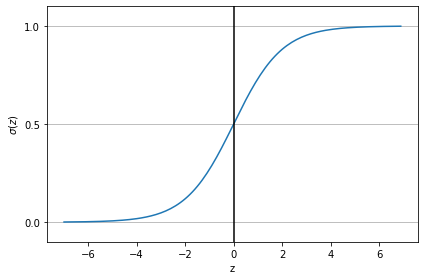

In [17]:
# visualize the sigmoid
import matplotlib.pyplot as plt
import numpy as np
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()

## Learning model weights from logistic loss function

For Adaline, we defined the mean squared error loss:
$$ L(\textbf{w}, b|\textbf{x}) = \sum_i \frac{1}{2}(\sigma (z_i) - (y_i))^2$$

For the logistic regression model, we want to work with the likelihood:
$$ L(\textbf{w}, b|\textbf{x}) = p(y|\textbf{x}; \textbf{w}, b) = \prod_{i=1}^n p(y_i|\textbf{x}_i; \textbf{w}, b) =
 \prod_{i=1}^n (\sigma(z_i))^{y_i} (1 - \sigma(z_i))^{(1 - y_i)}$$

Rather than work with products, we instead use the **log-likelihood**:
$$ l(\textbf{w}, b|\textbf{x}) = \text{log} L(\textbf{w}, b|\textbf{x}) = \sum_{i=1} [y_i \ \text{log}(\sigma(z_i)) + (1 - y_i)\ \text{log}\ (1 - \sigma(z_i))] $$

We can use an optimizer to maximize the log-likelihood, but instead we usually invert this likelihood into a loss function and minimize the **negative log-likelihood**
$$ - \frac{1}{n} \sum_{i=1} [y_i \ \text{log}(\sigma(z_i)) + (1 - y_i)\ \text{log}\ (1 - \sigma(z_i))]  $$

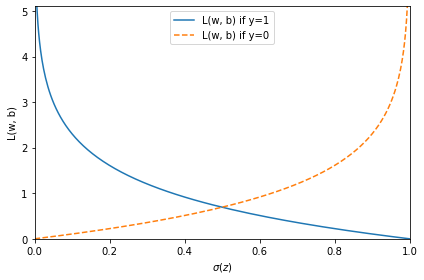

In [18]:
# Loss for a single training example
def loss_1(z):
    return - np.log(sigmoid(z))

def loss_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
c0 = [loss_0(x) for x in z]

plt.plot(sigma_z, c1, label='L(w, b) if y=1')
plt.plot(sigma_z, c0, label='L(w, b) if y=0', linestyle='--')

plt.ylim(0.0, 5.1)
plt.xlim(0, 1)
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()

In [74]:
# Implementation of Logistic Regression with full batch gradient descent
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier
    
    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Number of passes over the training dataset
    random_state : int
        Seed for random number generator
    
    Attributes:
    -----------
    w_ : 1d-array
        Weights after training
    b_ : Scalar
        Bias unit after fitting
    losses_ : list
        Mean squared error loss function vlaues in each epoch
    
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is # of examples
            and n_features is # of features
        y : array_like, shape = [n_examples]
            Target values
        Returns
        -------
        self : Instance of LogisiticRegressionGD
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.ests = [ [self.w_[0], self.w_[1], self.b_] ]
        self.losses_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (
                ( -y.dot(np.log(output)) - ((1-y).dot(np.log(1 - output))))
                / X.shape[0]
            )
            self.losses_.append(loss)
            self.ests.append([self.w_[0], self.w_[1], self.b_])
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

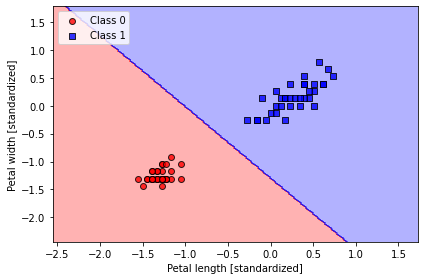

In [75]:
X_train_01 = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01 = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(
    eta=0.3, n_iter=1000, random_state=1
)
lrgd.fit(X_train_01, y_train_01)
plot_decision_regions(X=X_train_01,
                      y=y_train_01,
                      classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()


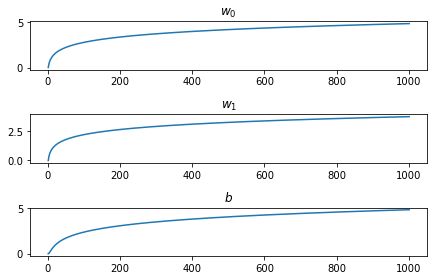

In [81]:
x = np.arange(0,1001)+1
ests = np.array(lrgd.ests)
fig, ax = plt.subplots(3, 1)
ax[0].plot(x, ests[:,0])
ax[1].plot(x, ests[:,1])
ax[2].plot(x, ests[:,2])
ax[0].set_title('$w_0$')
ax[1].set_title('$w_1$')
ax[2].set_title('$b$')
fig.tight_layout()

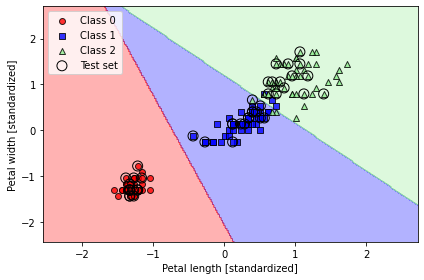

In [82]:
# same but in sklearn
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std, y_combined, classifier=lr,
    test_idx = range(105, 150)
)

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend()
plt.tight_layout()

In [88]:
lr.predict_proba(X_test_std[:5,:]).round(3)

array([[0.   , 0.145, 0.855],
       [0.834, 0.166, 0.   ],
       [0.849, 0.151, 0.   ],
       [0.   , 0.694, 0.306],
       [0.   , 0.983, 0.017]])

In [89]:
lr.predict_proba(X_test_std[:5,:]).argmax(axis=1)

array([2, 0, 0, 1, 1])

In [90]:
# remember, you need to pass in a 2d X matrix, so you have to transform a 1d vector for single prediction
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

## Tackling overfitting via regularization

* **overfitting**: high variance, too many parameters - the model changes based on which part of the data it is trained on
* **underfitting**: high bias, not enough parameters - the model is stable, but its predictions are far from the true values

We can add a regularization paramter to help adjust the bias-variance tradeoff.

For instance, the common **L2 regularization** uses the L2 norm to penalize extreme parameter weights:
$$ \frac{\lambda}{2n} \textbf{||w||}^2 =  \frac{\lambda}{2n} \sum_{j-1}^m w_j^2$$

The $\lambda$ is the regularization parameter, and gets added to the loss function to shrink the weights during model training


$$ \frac{1}{n} \sum_{i=1} [- y_i \ \text{log}(\sigma(z_i)) - (1 - y_i)\ \text{log}\ (1 - \sigma(z_i))] + \frac{\lambda}{2n} \textbf{||w||}^2
$$

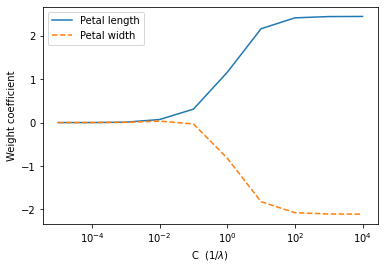

In [94]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='Petal length')
plt.plot(params, weights[:, 1], label='Petal width', linestyle='--')
plt.ylabel('Weight coefficient')
plt.xlabel('C  ($1/\lambda$)')
plt.legend()
plt.xscale('log')

## Maximum margin classification with support vector machines

With the perceptron algorithm, the goal is the minimize misclassification errors. In SVMs, the optimization objective is the maximize the margin - i.e. the distance between the separating hyperplane (decision boundary) and the training examples which are closest to the hyperplane (the **support vectors**).

The $C$ parameter in SVM is a hyperparameter that controls how mch to penalize misclassification. When $C$ is small, the misclassification penality is less strict, leading to a larger margin - which in turn leads to lower variance (overfitting) and higher bias (underfitting).

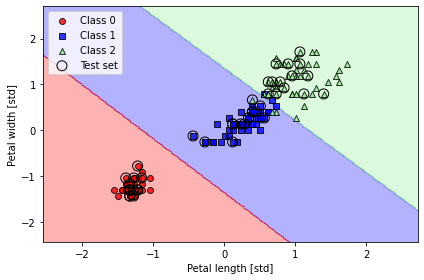

In [101]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std, y_combined, classifier=svm,
    test_idx = range(105, 150)
)
plt.xlabel('Petal length [std]')
plt.ylabel('Petal width [std]')
plt.legend()
plt.tight_layout()

#### Logistic Regression vs SVMs
Linear LogReg and SVM with a linear kernel often yield similar results. LogReg tries to maximize the conditional likelihoods of the training data, which makes it more sensitive to outliers than SVM. On the other hand, LogReg is a simpler model which can be implemented more easily, and is easier to explain. Moreover, LogReg models can be updated easily.

# Solving nonlinear problems using a kernel SVM

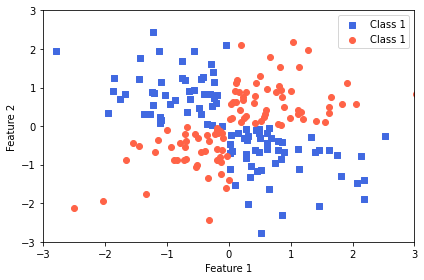

In [102]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(
    X_xor[:,0] > 0,
    X_xor[:, 1] > 0
)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(
    X_xor[y_xor == 1, 0],
    X_xor[y_xor == 1, 1],
    c = 'royalblue', marker = 's',
    label = 'Class 1'
)
plt.scatter(
    X_xor[y_xor == 0, 0],
    X_xor[y_xor == 0, 1],
    c = 'tomato', marker = 'o',
    label = 'Class 1'
)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()

The **kernel method** allows us to apply the SVM approach to data that are not linearly separable by projecting the data into a higher-dimensional space. The mapping function $\phi$, accomplishes this, transforming the data into a space where the classes become linearly separable.

However, solving the SVM requires computing the dot product between points $x_i^Tx_j$ which becomes very computationally expensive. Instead, we can use the **kernel trick** to define a kernal function:
$$ \kappa(x_i, x_j) = \phi(x_i)^T\phi(x_j) $$

One of the most common is the **radial basis function (RBF)** which could also be called the **Gaussian kernel**

$$ \kappa(x_i, x_j) = \text{exp} (- \frac{||x_i - x_j||^2}{2\sigma^2} )$$

This is often simplied: $ \kappa(x_i, x_j) = \text{exp} (- \gamma||x_i - x_j||^2) $ where $\gamma = \frac{1}{2\sigma^2}$ which is a hyperparameter to be optimized.

The "kernel" can loosely be interpreted as a similarity score between pairs of examples. The minus sign inverts the distance metric into the similar score, and the exponential forces the score to range from 0 (very dissimilar) to 1 (exactly similar).

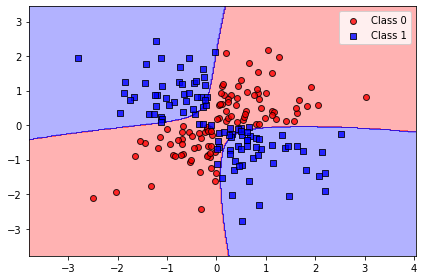

In [103]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend()
plt.tight_layout()

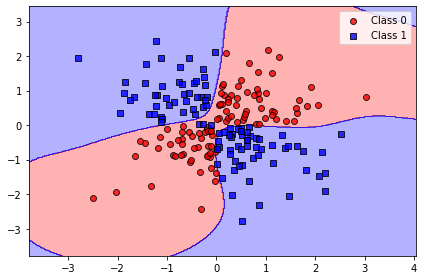

In [104]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.50, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend()
plt.tight_layout()

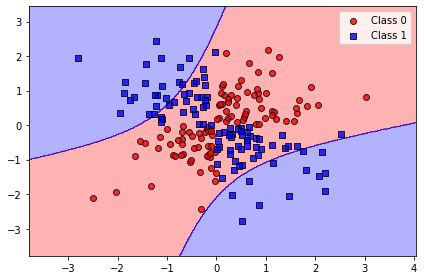

In [105]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.01, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend()
plt.tight_layout()

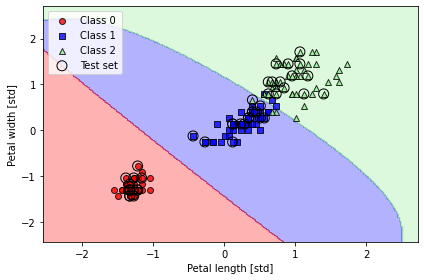

In [107]:
# apply to the iris data
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std, y_combined, classifier=svm,
    test_idx = range(105, 150)
)
plt.xlabel('Petal length [std]')
plt.ylabel('Petal width [std]')
plt.legend()
plt.tight_layout()

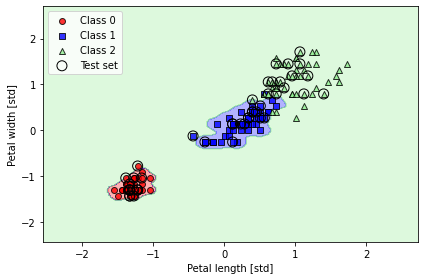

In [108]:
# apply to the iris data
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std, y_combined, classifier=svm,
    test_idx = range(105, 150)
)
plt.xlabel('Petal length [std]')
plt.ylabel('Petal width [std]')
plt.legend()
plt.tight_layout()

# Decision tree learning

## Maximizing IG
The goal is to split data at nodes that give the largest **information gain (IG)**. To optimize this, we use as objective function to maximize the IG at each split:

$$
IG(D_p, f) = I(D_p) - \sum_{j=1}^m\frac{N_j}{N_p}I(D_j)
$$

$D_p$ is the parent node and $f$ is the feature to split on. The information gain is the impurity of the parent $I(D_p)$ minus the sum of the impurity of each $j$ child node $I(D_j)$. To limit the search space, each parent is allowed to two child nodes, $D_{left}$ and $D_{right}$, so the information gain is:

$$
IG(D_p, f) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right})
$$

The three most common impurity measures are **entropy** ($I_H$), **Gini impurity** ($I_G$), and **classification error** ($I_E$).

### Entropy
For all non-empty classes ($p(i|t) \neq 0$), entropy is:
$$
I_H(t) = - \sum_{i=1}^c p(i|t)\ \text{log}_2\ p(i|t)
$$

Here, $p(i|t)$ is the proportion of examples that belong to class $i$ for node $t$. It is 0 if all examples in the node belong to the same class, and maximal when classes are uniformly distributed. The entropy criterion attempts to maximize the mutual information in the tree.

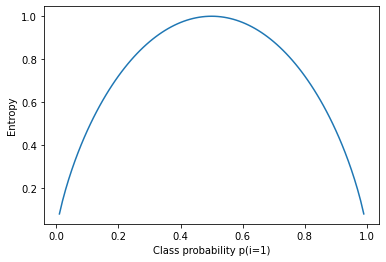

In [113]:
def entropy(p):
    return - p * np.log2(p) - (1-p) * np.log2( (1-p) )

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('Class probability p(i=1)')
plt.plot(x, ent)

### Gini impurity
The Gini criterion minimizes the probability of misclassification
$$
I_G(t)=\sum_{t=1}^c p(i|t)(1-p(i|t)) = 1 = \sum_{i=1}^c p(i|t)^2
$$

Like entropy, the Gini impurity is maximial if the classes are perfectly mixed. In a binary context ($c$ = 2):
$$ I_G(t) = 1 - \sum{i=1}^2 0.5^2 = 0.5 $$

In practice, Gini impurity and entropy produce similar results and are often not worth trying to switch between them (instead change different purning cutoffs)

### Misclassification error
This criteria is useful for pruning, but not growing trees:
$$
I_E(t) = 1 - \text{max}(p(i|t))
$$

Text(0, 0.5, 'Impurity index')

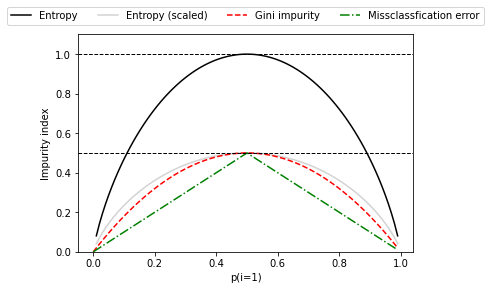

In [114]:
## Visualize all three (scaling entropy)

import matplotlib.pyplot as plt
import numpy as np

def gini(p):
    return p*(1-p) + (1-p)*(1 - (1-p))

def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1-p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig, ax = plt.subplots()
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)', 'Gini impurity',
                           'Missclassfication error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim(0, 1.1)
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')

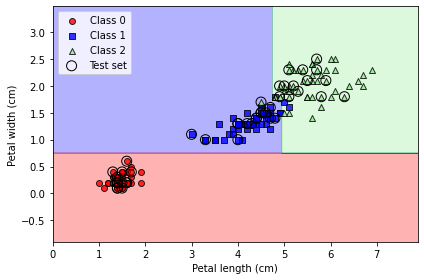

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    random_state=1
)
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X_combined, y_combined, classifier=tree_model,
    test_idx = range(105, 150)
)
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout()

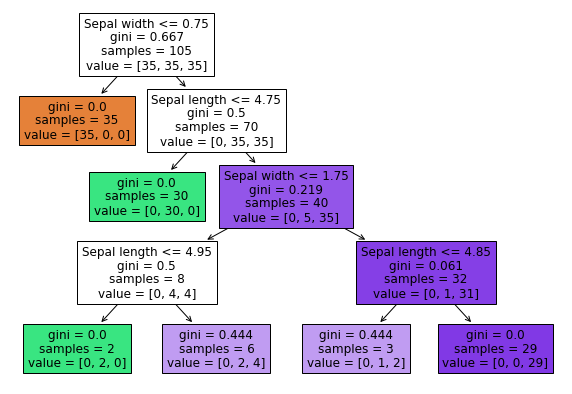

In [11]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']

fig, ax = plt.subplots(figsize=(10,7))
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True,
               ax=ax);

## Combining multiple decision trees via random forests

Ensembles are great - good performance and robustness to overfitting.

Random forest overview:

1. Draw a random bootstrap sample of size _n_
2. Grow a decision tree from the boostrap sample.

    2.1. Randomly select _d_ features without replacement

    2.2. Split the node using the feature that provides the best split (based on info gain according to objective function)

3. Repeat Steps 1-2 _k_ times
4. Aggregate the prediction by each tree to assign the class label by **majority vote**.


scikit-learn uses sensible defaults for some of the hyperparameters
* _n_ (bootstramp sample size) is equal to the original sample size
* _d_ (number of features to sample) is equal to the square root of the features ($\sqrt{p}$)

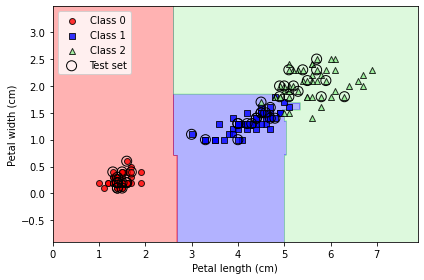

In [12]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(
    n_estimators=25, random_state=1, n_jobs=-2
)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined,
                      classifier=forest, test_idx=range(105, 150))
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout()

# K-nearest neighbors (KNN) - a lazy learning algorithm

KNN is **lazy** because rather than learn a discriminant function, it memorizes the training data.

KNN is a subcategory of **non-parametric methods** - it is an example of **instance-based learning**.

KNN is fairly straightforward:
1. Choose the number _k_ of groups and a distance metric
2. Find the _k_-nearest neighbors of the data you want to classify
3. Assign the class label by majority vote

For each new data point, KNN then finds the _k_ nearest training examples, and assigns it the majority label of those training samples.

sklearn uses these tie-breaking rules:
1. Use the class for the closest neighbor
2. Use the class label that appears first in the training dataset

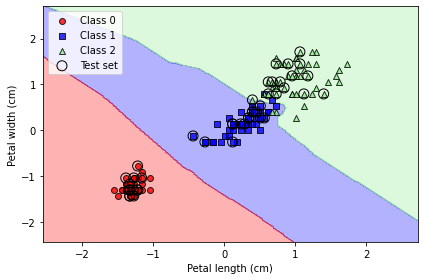

In [19]:
# KNN using Euclidean distance
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
classifier=knn, test_idx=range(105, 150))
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout()


The `minkowski` distance is a generalization of Euclidean and Manhattan distance:
$$
d(x_i, x_j) = \sqrt[p]{\sum_k |x_{i,k} - x_{j,k}|^p}
$$

So when `p=1` we get Manhattan distance, when `p=2` we get Euclidean distance

### The Curse of Dimensionality
KNN is very susceptible to overfitting as the feature space grows. As the number of features increase, the training data become more sparse in the high-dimensional feature space. There, even the closest neighbors might be too far away to provide a good estimate.

Whereas logistic regression can benefit from regularization, that isn't applicable to models like decision trees or KNNs. Instead, feature selection and dimensionality reduction can help avoid the curse of dimensionality and prevent overfitting.